In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as de
import dedalus.extras.plot_tools as plot_tools
import atmospheres as atmos
import parameters as param
import mpi4py.MPI as MPI
import tides
import uuid
import logging
logger = logging.getLogger(__name__)
%matplotlib notebook

ModuleNotFoundError: No module named 'tides'

In [ ]:
import importlib
importlib.reload(param)

## Background

In [32]:
# Background BVP
domain, p_bvp = atmos.solve_hydrostatic_pressure(param, np.float64)
p_full, p_trunc, a_full, a_trunc, heq, N2 = atmos.truncate_background(param, p_bvp)

2017-07-21 13:50:11,545 domain 0/1 DEBUG :: Global coeff shape: [128]
2017-07-21 13:50:11,546 distributor 0/1 DEBUG :: Mesh: []
2017-07-21 13:50:11,548 problems 0/1 DEBUG :: Parsing Eqn 0
2017-07-21 13:50:11,549 problems 0/1 DEBUG ::   Condition: True
2017-07-21 13:50:11,550 problems 0/1 DEBUG ::   LHS string form: dz(pz) + (N2/g)*pz
2017-07-21 13:50:11,550 problems 0/1 DEBUG ::   RHS string form: pz*pz/p/γ
2017-07-21 13:50:11,552 problems 0/1 DEBUG ::   LHS object form: dz(pz) + ((N2*(g**-1))*pz)
2017-07-21 13:50:11,553 problems 0/1 DEBUG ::   RHS object form: ((pz*pz)*(p**-1))*(γ**-1)
2017-07-21 13:50:11,557 problems 0/1 DEBUG ::   L linear form: dz(δpz) + ((N2*(g**-1))*δpz)
2017-07-21 13:50:11,559 problems 0/1 DEBUG ::   dF linear form: ((((pz*pz)*(-1*(p**-2)))*(γ**-1))*δp) + ((((pz*(p**-1))*(γ**-1))*δpz) + (((pz*(p**-1))*(γ**-1))*δpz))
2017-07-21 13:50:11,560 problems 0/1 DEBUG :: Parsing Eqn 1
2017-07-21 13:50:11,561 problems 0/1 DEBUG ::   Condition: True
2017-07-21 13:50:11,562 

In [33]:
# IVP domain
x_basis = de.Fourier('x', param.Nx, interval=(0, param.Lx), dealias=3/2)
z_basis = de.Chebyshev('z', param.Nz, interval=(0, param.Lz), dealias=3/2)
domain = de.Domain([x_basis, z_basis], grid_dtype=np.float64)

# Background state
a0 = domain.new_field()
p0 = domain.new_field()
u0 = domain.new_field()
a0.meta['x']['constant'] = True
p0.meta['x']['constant'] = True
u0.meta['x']['constant'] = True

a0.set_scales(1)
p0.set_scales(1)
slices = domain.dist.grid_layout.slices(scales=1)
a_trunc.set_scales(1)
p_trunc.set_scales(1)
a0['g'][:] = a_trunc['g'][slices[1]]
p0['g'][:] = p_trunc['g'][slices[1]]

u0['g'] = param.U

2017-07-21 13:50:12,234 domain 0/1 DEBUG :: Global coeff shape: [  8 128]
2017-07-21 13:50:12,235 distributor 0/1 DEBUG :: Mesh: []
2017-07-21 13:50:12,239 basis 0/1 DEBUG :: Building FFTW DCT plan for (dtype, gshape, axis) = (complex128, (8, 128), 1)
2017-07-21 13:50:12,240 basis 0/1 DEBUG :: Building FFTW FFT plan for (dtype, gshape, axis) = (float64, (16, 128), 0)


## Problem

In [34]:
# Adiabatic viscous fully-compressible hydrodynamics
problem = de.LBVP(domain, variables=['a1','p1','u1','w1','uz1','wz1'], 
    ncc_cutoff=param.ivp_cutoff, entry_cutoff=param.matrix_cutoff)
problem.meta[:]['z']['dirichlet'] = True
problem.parameters['a0'] = a0
problem.parameters['p0'] = p0
problem.parameters['u0'] = u0
problem.parameters['az0'] = a0.differentiate('z')
problem.parameters['pz0'] = p0.differentiate('z')
problem.substitutions['w0'] = "0"
problem.substitutions['uz0'] = "0" #u0.differentiate('z')
problem.substitutions['wz0'] = "0" #w0.differentiate('z')
problem.parameters['μ'] = param.μ
problem.parameters['γ'] = param.γ
problem.parameters['k'] = param.k_tide
problem.parameters['A'] = param.A_tide
problem.parameters['Lz'] = param.Lz
problem.substitutions['az1'] = "dz(a1)"
problem.substitutions['pz1'] = "dz(p1)"
problem.substitutions['φ'] = "A*cos(k*x)*exp(k*(z - Lz))"
problem.substitutions['txx(u, w, uz, wz)'] = "μ*(2*dx(u) - 2/3*(dx(u) + wz))"
problem.substitutions['txz(u, w, uz, wz)'] = "μ*(dx(w) + uz)"
problem.substitutions['tzz(u, w, uz, wz)'] = "μ*(2*wz - 2/3*(dx(u) + wz))"
problem.substitutions['fu(a_L, p_L, u_L, w_L, az_L, pz_L, uz_L, wz_L, a_R, p_R, u_R, w_R, az_R, pz_R, uz_R, wz_R)'] = "- (u_L*dx(u_R) + w_L*uz_R) - a_L*dx(p_R) + a_L*(dx(txx(u_R, w_R, uz_R, wz_R)) + dz(txz(u_R, w_R, uz_R, wz_R)))"
problem.substitutions['fw(a_L, p_L, u_L, w_L, az_L, pz_L, uz_L, wz_L, a_R, p_R, u_R, w_R, az_R, pz_R, uz_R, wz_R)'] = "- (u_L*dx(w_R) + w_L*wz_R) - a_L*pz_R    + a_L*(dx(txz(u_R, w_R, uz_R, wz_R)) + dz(tzz(u_R, w_R, uz_R, wz_R)))"
problem.substitutions['fa(a_L, p_L, u_L, w_L, az_L, pz_L, uz_L, wz_L, a_R, p_R, u_R, w_R, az_R, pz_R, uz_R, wz_R)'] = "- (u_L*dx(a_R) + w_L*az_R) + a_L*(dx(u_R) + wz_R)"
problem.substitutions['fp(a_L, p_L, u_L, w_L, az_L, pz_L, uz_L, wz_L, a_R, p_R, u_R, w_R, az_R, pz_R, uz_R, wz_R)'] = "- (u_L*dx(p_R) + w_L*pz_R) - γ*p_L*(dx(u_R) + wz_R)"
problem.substitutions['fu_01'] = "fu(a0, p0, u0, w0, az0, pz0, uz0, wz0, a1, p1, u1, w1, az1, pz1, uz1, wz1)"
problem.substitutions['fw_01'] = "fw(a0, p0, u0, w0, az0, pz0, uz0, wz0, a1, p1, u1, w1, az1, pz1, uz1, wz1)"
problem.substitutions['fa_01'] = "fa(a0, p0, u0, w0, az0, pz0, uz0, wz0, a1, p1, u1, w1, az1, pz1, uz1, wz1)"
problem.substitutions['fp_01'] = "fp(a0, p0, u0, w0, az0, pz0, uz0, wz0, a1, p1, u1, w1, az1, pz1, uz1, wz1)"
problem.substitutions['fu_10'] = "fu(a1, p1, u1, w1, az1, pz1, uz1, wz1, a0, p0, u0, w0, az0, pz0, uz0, wz0)"
problem.substitutions['fw_10'] = "fw(a1, p1, u1, w1, az1, pz1, uz1, wz1, a0, p0, u0, w0, az0, pz0, uz0, wz0)"
problem.substitutions['fa_10'] = "fa(a1, p1, u1, w1, az1, pz1, uz1, wz1, a0, p0, u0, w0, az0, pz0, uz0, wz0)"
problem.substitutions['fp_10'] = "fp(a1, p1, u1, w1, az1, pz1, uz1, wz1, a0, p0, u0, w0, az0, pz0, uz0, wz0)"
problem.substitutions['Hu'] = "-dx(φ)"
problem.substitutions['Hw'] = "-dz(φ)"
problem.add_equation("fu_01 + fu_10 = -Hu", condition="nx != 0")
problem.add_equation("fw_01 + fw_10 = -Hw", condition="nx != 0")
problem.add_equation("fa_01 + fa_10 = 0", condition="nx != 0")
problem.add_equation("fp_01 + fp_10 = 0", condition="nx != 0")
problem.add_equation("uz1 - dz(u1) = 0", condition="nx != 0")
problem.add_equation("wz1 - dz(w1) = 0", condition="nx != 0")
problem.add_bc("left(txz(u1, w1, uz1, wz1)) = 0", condition="nx != 0")
problem.add_bc("right(txz(u1, w1, uz1, wz1)) = 0", condition="nx != 0")
problem.add_bc("left(w1) = 0", condition="nx != 0")
problem.add_bc("right(w1) = 0", condition="nx != 0")

problem.add_equation("a1 = 0", condition="nx == 0")
problem.add_equation("p1 = 0", condition="nx == 0")
problem.add_equation("u1 = 0", condition="nx == 0")
problem.add_equation("w1 = 0", condition="nx == 0")
problem.add_equation("uz1 = 0", condition="nx == 0")
problem.add_equation("wz1 = 0", condition="nx == 0")

2017-07-21 13:50:12,371 problems 0/1 DEBUG :: Parsing Eqn 0
2017-07-21 13:50:12,372 problems 0/1 DEBUG ::   Condition: nx != 0
2017-07-21 13:50:12,373 problems 0/1 DEBUG ::   LHS string form: fu_01 + fu_10
2017-07-21 13:50:12,374 problems 0/1 DEBUG ::   RHS string form: -Hu
2017-07-21 13:50:12,382 problems 0/1 DEBUG ::   LHS object form: ((-1*(u0*dx(u1))) + (-1*(a0*dx(p1)))) + (a0*(dx(μ*((2*dx(u1)) + (-1*(0.6666666666666666*(dx(u1) + wz1))))) + dz(μ*(dx(w1) + uz1))))
2017-07-21 13:50:12,383 problems 0/1 DEBUG ::   RHS object form: -1*(-1*dx((A*cos(k*x))*exp(k*(z + (-1*Lz)))))
2017-07-21 13:50:12,393 problems 0/1 DEBUG ::   L linear form: (((-1*u0)*dx(u1)) + ((-1*a0)*dx(p1))) + ((((a0*μ)*dx(2*dx(u1))) + (((a0*μ)*dx(-0.6666666666666666*dx(u1))) + ((a0*μ)*dx(-0.6666666666666666*wz1)))) + (((a0*μ)*dz(dx(w1))) + ((a0*μ)*dz(uz1))))
2017-07-21 13:50:12,393 problems 0/1 DEBUG :: Parsing Eqn 1
2017-07-21 13:50:12,394 problems 0/1 DEBUG ::   Condition: nx != 0
2017-07-21 13:50:12,395 problems 0/

2017-07-21 13:50:12,483 problems 0/1 DEBUG ::   RHS object form: 0
2017-07-21 13:50:12,483 problems 0/1 DEBUG ::   L linear form: uz1
2017-07-21 13:50:12,484 problems 0/1 DEBUG :: Parsing Eqn 11
2017-07-21 13:50:12,485 problems 0/1 DEBUG ::   Condition: nx == 0
2017-07-21 13:50:12,485 problems 0/1 DEBUG ::   LHS string form: wz1
2017-07-21 13:50:12,486 problems 0/1 DEBUG ::   RHS string form: 0
2017-07-21 13:50:12,487 problems 0/1 DEBUG ::   LHS object form: wz1
2017-07-21 13:50:12,487 problems 0/1 DEBUG ::   RHS object form: 0
2017-07-21 13:50:12,488 problems 0/1 DEBUG ::   L linear form: wz1


## Solver

In [35]:
# Build solver
solver = problem.build_solver()
solver.solve()
print(np.linalg.cond(solver.pencils[0].L.A))

2017-07-21 13:50:12,511 solvers 0/1 DEBUG :: Beginning LBVP instantiation
2017-07-21 13:50:12,517 field 0/1 DEBUG :: Expanded NCC '-1*u0' to mode 0 with 1 terms.
2017-07-21 13:50:12,604 field 0/1 DEBUG :: Expanded NCC '-1*a0' to mode 33 with 34 terms.
2017-07-21 13:50:12,634 field 0/1 DEBUG :: Expanded NCC 'a0*μ' to mode 10 with 11 terms.
2017-07-21 13:50:12,664 field 0/1 DEBUG :: Expanded NCC 'a0*μ' to mode 10 with 11 terms.
2017-07-21 13:50:12,695 field 0/1 DEBUG :: Expanded NCC 'a0*μ' to mode 10 with 11 terms.
2017-07-21 13:50:12,725 field 0/1 DEBUG :: Expanded NCC 'a0*μ' to mode 10 with 11 terms.
2017-07-21 13:50:12,774 field 0/1 DEBUG :: Expanded NCC 'a0*μ' to mode 10 with 11 terms.
2017-07-21 13:50:12,779 field 0/1 DEBUG :: Expanded NCC '-1*u0' to mode 0 with 1 terms.
2017-07-21 13:50:12,864 field 0/1 DEBUG :: Expanded NCC '-1*a0' to mode 33 with 34 terms.
2017-07-21 13:50:12,895 field 0/1 DEBUG :: Expanded NCC 'a0*μ' to mode 10 with 11 terms.
2017-07-21 13:50:12,925 field 0/1 DE

In [36]:
for pencil in solver.pencils:
    print(np.linalg.cond(pencil.L_exp.A))
    print(np.linalg.cond(pencil.L.A))
    print()

82.1016272935
1.0

1480658310.78
341627309.869

1592658408.79
1261687902.56

1663377305.04
298498531.003

1716525315.01
288113128.519

1759512370.04
280300807.951

1795895743.11
274071471.322

1827620672.99
268910518.434



<IPython.core.display.Javascript object>


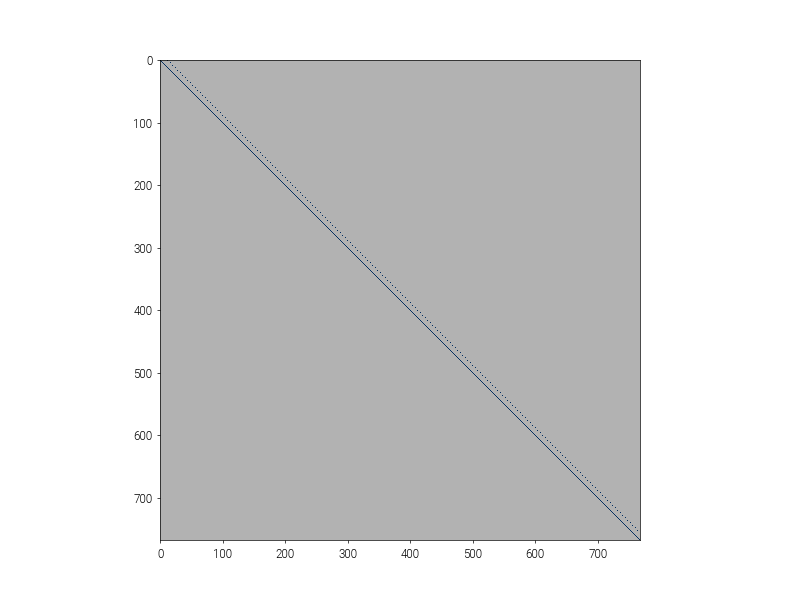

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


(array([], dtype=int64),)

In [37]:
plt.figure()
L = solver.pencils[0].L_exp
plt.imshow(np.log10(np.abs(L.A)))

np.where(np.sum(np.abs(L.A), axis=0) == 0)

<IPython.core.display.Javascript object>


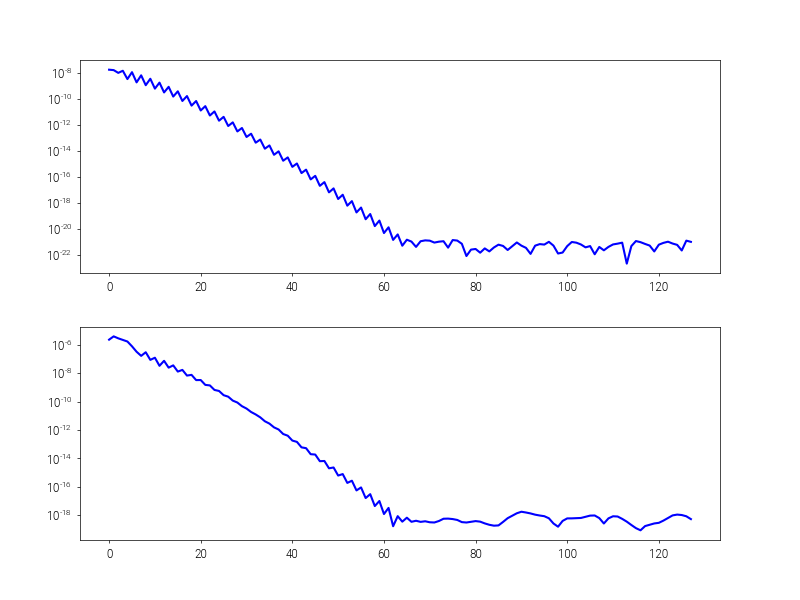

In [38]:
scales = 1
z = domain.grid(0, scales=scales)

fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.semilogy(np.abs(solver.state['p1']['c'][2]))
ax2.semilogy(np.abs(solver.state['a1']['c'][2]))

2017-07-21 13:50:20,759 basis 0/1 DEBUG :: Building FFTW DCT plan for (dtype, gshape, axis) = (complex128, (8, 1280), 1)
2017-07-21 13:50:20,760 basis 0/1 DEBUG :: Building FFTW FFT plan for (dtype, gshape, axis) = (float64, (160, 1280), 0)


<IPython.core.display.Javascript object>


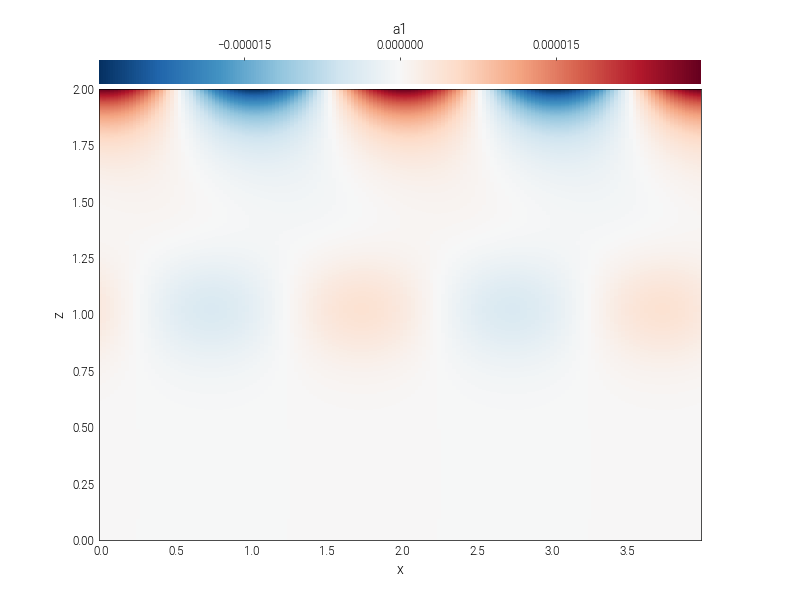

(<matplotlib.axes._axes.Axes at 0x1110fd198>,
 <matplotlib.axes._axes.Axes at 0x1112d42e8>)

In [39]:
scales = 10
from dedalus.extras import plot_tools

field = 'a1'
f = solver.state[field]
f.set_scales(scales)
f.require_grid_space()
fig, axes = plt.subplots(1, 1)
plot_tools.plot_bot_2d(f, axes=axes)

In [ ]:
# Adiabatic viscous fully-compressible hydrodynamics
problem = de.LBVP(domain, variables=['a1','p1','u1','w1','uz1','wz1'], 
    ncc_cutoff=param.ivp_cutoff, entry_cutoff=param.matrix_cutoff)
problem.meta[:]['z']['dirichlet'] = True
problem.parameters['a0'] = a0
problem.parameters['p0'] = p0
problem.parameters['u0'] = u0
problem.parameters['az0'] = a0.differentiate('z')
problem.parameters['pz0'] = p0.differentiate('z')
problem.substitutions['w0'] = "0"
problem.substitutions['uz0'] = "0" #u0.differentiate('z')
problem.substitutions['wz0'] = "0" #w0.differentiate('z')
problem.parameters['μ'] = param.μ
problem.parameters['γ'] = param.γ
problem.parameters['k'] = param.k_tide
problem.parameters['A'] = param.A_tide
problem.parameters['Lz'] = param.Lz
problem.substitutions['az1'] = "dz(a1)"
problem.substitutions['pz1'] = "dz(p1)"
problem.substitutions['φ'] = "A*cos(k*x)*exp(k*(z - Lz))"
problem.substitutions['txx(u, w, uz, wz)'] = "μ*(2*dx(u) - 2/3*(dx(u) + wz))"
problem.substitutions['txz(u, w, uz, wz)'] = "μ*(dx(w) + uz)"
problem.substitutions['tzz(u, w, uz, wz)'] = "μ*(2*wz - 2/3*(dx(u) + wz))"
problem.substitutions['fu(a_L, p_L, u_L, w_L, az_L, pz_L, uz_L, wz_L, a_R, p_R, u_R, w_R, az_R, pz_R, uz_R, wz_R)'] = "- (u_L*dx(u_R) + w_L*uz_R) - a_L*dx(p_R) + a_L*(dx(txx(u_R, w_R, uz_R, wz_R)) + dz(txz(u_R, w_R, uz_R, wz_R)))"
problem.substitutions['fw(a_L, p_L, u_L, w_L, az_L, pz_L, uz_L, wz_L, a_R, p_R, u_R, w_R, az_R, pz_R, uz_R, wz_R)'] = "- (u_L*dx(w_R) + w_L*wz_R) - a_L*pz_R    + a_L*(dx(txz(u_R, w_R, uz_R, wz_R)) + dz(tzz(u_R, w_R, uz_R, wz_R)))"
problem.substitutions['fa(a_L, p_L, u_L, w_L, az_L, pz_L, uz_L, wz_L, a_R, p_R, u_R, w_R, az_R, pz_R, uz_R, wz_R)'] = "- (u_L*dx(a_R) + w_L*az_R) + a_L*(dx(u_R) + wz_R)"
problem.substitutions['fp(a_L, p_L, u_L, w_L, az_L, pz_L, uz_L, wz_L, a_R, p_R, u_R, w_R, az_R, pz_R, uz_R, wz_R)'] = "- (u_L*dx(p_R) + w_L*pz_R) - γ*p_L*(dx(u_R) + wz_R)"
problem.substitutions['fu_01'] = "fu(a0, p0, u0, w0, az0, pz0, uz0, wz0, a1, p1, u1, w1, az1, pz1, uz1, wz1)"
problem.substitutions['fw_01'] = "fw(a0, p0, u0, w0, az0, pz0, uz0, wz0, a1, p1, u1, w1, az1, pz1, uz1, wz1)"
problem.substitutions['fa_01'] = "fa(a0, p0, u0, w0, az0, pz0, uz0, wz0, a1, p1, u1, w1, az1, pz1, uz1, wz1)"
problem.substitutions['fp_01'] = "fp(a0, p0, u0, w0, az0, pz0, uz0, wz0, a1, p1, u1, w1, az1, pz1, uz1, wz1)"
problem.substitutions['fu_10'] = "fu(a1, p1, u1, w1, az1, pz1, uz1, wz1, a0, p0, u0, w0, az0, pz0, uz0, wz0)"
problem.substitutions['fw_10'] = "fw(a1, p1, u1, w1, az1, pz1, uz1, wz1, a0, p0, u0, w0, az0, pz0, uz0, wz0)"
problem.substitutions['fa_10'] = "fa(a1, p1, u1, w1, az1, pz1, uz1, wz1, a0, p0, u0, w0, az0, pz0, uz0, wz0)"
problem.substitutions['fp_10'] = "fp(a1, p1, u1, w1, az1, pz1, uz1, wz1, a0, p0, u0, w0, az0, pz0, uz0, wz0)"
problem.substitutions['Hu'] = "-dx(φ)"
problem.substitutions['Hw'] = "-dz(φ)"
problem.add_equation("fu_01 + fu_10 = -Hu", condition="nx != 0")
problem.add_equation("fw_01 + fw_10 = -Hw", condition="nx != 0")
problem.add_equation("fa_01 + fa_10 = 0", condition="nx != 0")
problem.add_equation("fp_01 + fp_10 = 0", condition="nx != 0")
problem.add_equation("uz1 - dz(u1) = 0", condition="nx != 0")
problem.add_equation("wz1 - dz(w1) = 0", condition="nx != 0")
problem.add_bc("left(txz(u1, w1, uz1, wz1)) = 0", condition="nx != 0")
problem.add_bc("right(txz(u1, w1, uz1, wz1)) = 0", condition="nx != 0")
problem.add_bc("left(w1) = 0", condition="nx != 0")
problem.add_bc("right(w1) = 0", condition="nx != 0")

problem.add_equation("a1 = 0", condition="nx == 0")
problem.add_equation("p1 = 0", condition="nx == 0")
problem.add_equation("u1 = 0", condition="nx == 0")
problem.add_equation("w1 = 0", condition="nx == 0")
problem.add_equation("uz1 = 0", condition="nx == 0")
problem.add_equation("wz1 = 0", condition="nx == 0")